<a href="https://colab.research.google.com/github/Schimmenti/EarthquakesGPS/blob/main/Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import time
from scipy.ndimage.filters import maximum_filter1d, minimum_filter1d
from google.colab import drive
from sklearn.metrics import roc_curve
drive.mount('/content/drive')
from sklearn.neighbors import  KDTree,BallTree


def max_filter1d_valid(a, W, add_heading_nan=True):
    hW = (W-1)//2 # Half window size
    if(add_heading_nan):
      if(W%2==1):
        return np.concatenate([np.ones(W-1)*np.nan,maximum_filter1d(a,size=W)[hW:-hW]])
      else:
        return np.concatenate([np.ones(W-2)*np.nan,maximum_filter1d(a,size=W)[hW:-hW]])
    else:
      return maximum_filter1d(a,size=W)[hW:-hW]
def min_filter1d_valid(a, W, add_heading_nan=True):
    hW = (W-1)//2 # Half window size
    if(add_heading_nan):
      if(W%2==1):
        return np.concatenate([np.ones(W-1)*np.nan,minimum_filter1d(a,size=W)[hW:-hW]])
      else:
        return np.concatenate([np.ones(W-2)*np.nan,minimum_filter1d(a,size=W)[hW:-hW]])
    else:
      return minimum_filter1d(a,size=W)[hW:-hW]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
def haversine(lat1, lat2, delta_long):
  return np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(delta_long/2)**2

In [182]:
def moving_lin_regress(x, T, t0, t1, add_heading_nan=True):
    m = []
    for t in range(t0,t1-T):
        m.append(stats.linregress(np.arange(0,T),x[t:t+T])[0])
    if(add_heading_nan):
      return np.concatenate([np.ones(T)*np.nan, np.array(m)])
    else:
      return np.array(m)

In [183]:
base_link = "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/"

In [184]:
! wget "https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl"

--2022-03-22 15:34:39--  https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/gps_data/stat_info.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17030 (17K) [application/octet-stream]
Saving to: ‘stat_info.pkl.1’

stat_info.pkl.1     100%[===================>]  16.63K  --.-KB/s    in 0.001s  

2022-03-22 15:34:40 (32.0 MB/s) - ‘stat_info.pkl.1’ saved [17030/17030]



In [185]:
with open("stat_info.pkl","rb") as handle:
  station_names, station_pos = pkl.load(handle)

# Processing

In [ ]:
stat_data = {}
for name in station_names:
  try:
    stat_data[name] = pd.read_csv(base_link + name + ".csv")
  except:
    continue

In [ ]:
for name in stat_data.keys():
  #decimal_years  = stat_data[name]["DateD"].values
  #years = np.trunc(decimal_years).astype('int')
  #days_in_year = 365*np.ones(len(years), dtype=int)
  #days_in_year[days_in_year%4==0] += 1
  #days = np.round((decimal_years-years)*days_in_year).astype('int')
  #starting_date = datetime.date(years[0], 1, 1)
  #delta_days = datetime.timedelta(int(days[0]) - 1)
  #starting_date += delta_days
#
  #ending_date = datetime.date(years[-1]-1, 12, 31)
  #delta_days = datetime.timedelta(int(days[-1]))
  #ending_date += delta_days
  #print(ending_date)
  #del stat_data[name]["Date"]

  stat_data[name]['Date'] = pd.to_datetime(stat_data[name]['DateI'], format='%Y%m%d')
  stat_data[name].set_index("Date", drop=True, inplace=True)
  idx = pd.date_range(stat_data[name].index[0], stat_data[name].index[-1])
  stat_data[name] = stat_data[name].reindex(idx, fill_value=np.NaN)

In [ ]:
with open("stat_data.pkl", "wb") as handle:
  pkl.dump(stat_data,handle)

In [ ]:
W=9
coefs = {}
for name in stat_data.keys():
  nord = stat_data[name]["N"].values
  if(len(nord) >= W):
    T_w_nord = moving_lin_regress(nord, W, 0, len(nord))
    east = stat_data[name]["E"].values
    T_w_east = moving_lin_regress(east, W, 0, len(east))
    up = stat_data[name]["U"].values
    T_w_up = moving_lin_regress(up, W, 0, len(up))
    coefs[name] = np.array([T_w_nord, T_w_east, T_w_up])

In [ ]:
with open("T_W=%i.pkl"%W, "wb") as handle:
  pkl.dump(coefs,handle)

# Excursion

In [ ]:
up_scaling_factor = 4
excoefs = {}
for key in coefs.keys():
  temp = []
  for el in coefs[key]:
    temp.append(max_filter1d_valid(el, W)-min_filter1d_valid(el, W))
  #temp.append(np.sqrt(temp[0]**2+temp[1]**2+(temp[2]/up_scaling_factor)**2))
  temp = np.array(temp)
  excoefs[key] = temp

In [ ]:
with open("ex_T_W=%i.pkl" %W, "wb") as handle:
  pkl.dump(excoefs,handle)

In [ ]:
W_max=W
V_ws = {}
for key in excoefs.keys():
  V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
  if(len(V) <= W_max):
    V_windowed = V
  else:
    V_windowed = max_filter1d_valid(V, W_max)
  s_days = stat_data[key].index.values
  df = pd.DataFrame()
  df["Date"] = s_days
  df["V"] = V_windowed
  df.set_index("Date", drop=True, inplace=True)
  V_ws[key] = df
  if(len(s_days)!=excoefs[key].shape[1]):
    print("Sheit")

In [ ]:
with open("V_W=%i.pkl" %W_max, "wb") as handle:
  pkl.dump(V_ws,handle)

# Loading

In [186]:
catalog = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/catalog.csv",sep=r"\s+", index_col="Date")

In [187]:
W=9
W_max = W
with open("drive/MyDrive/Colab Notebooks/T_W=%i.pkl"%W,"rb") as handle:
  coefs = pkl.load(handle)
with open("drive/MyDrive/Colab Notebooks/ex_T_W=%i.pkl"%W,"rb") as handle:
  excoefs = pkl.load(handle)
with open("drive/MyDrive/Colab Notebooks/V_W=%i.pkl"%W_max,"rb") as handle:
  V_ws = pkl.load(handle)

In [188]:
with open("drive/MyDrive/Colab Notebooks/stat_data.pkl","rb") as handle:
  stat_data = pkl.load(handle)

# Catalog

In [ ]:
catalog = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/hauksson_relocated.dat",sep=r"\s+",header=None)
catalog.columns = ["sec","m","lat","long","dep"]

In [ ]:
landers = catalog[catalog["m"]==7.3]
landers_date = datetime.date(1992,6,28)
landers_time = datetime.timedelta(hours=11, minutes=57, seconds=33)
delta_time = datetime.timedelta(seconds=float(landers['sec'].values))
catalog_beginning = landers_date+landers_time-delta_time
catalog_seconds = catalog['sec'].values.astype('timedelta64[s]')
start_date = np.datetime64(catalog_beginning)
catalog_dates = start_date + catalog_seconds
year_integer =  catalog_dates.astype('datetime64[Y]').astype('int')+1970
month_integer =  catalog_dates.astype('datetime64[M]').astype('int')%12+1
day_integer = (catalog_dates- catalog_dates.astype('datetime64[M]') + 1).astype('timedelta64[D]').astype('int')+1
date_integer =(year_integer*10000+month_integer*100+day_integer)
pandas_datetime = pd.to_datetime(date_integer, format='%Y%m%d')
catalog["Date"] = pandas_datetime
catalog.set_index("Date", drop=True, inplace=True)

In [ ]:
catalog.to_csv("catalog.csv", sep="\t")

# Clustering

In [202]:
position_array = np.array([station_pos[key] for key in V_ws.keys()])
pos_rads = position_array*np.pi/180
pos_tree = BallTree(pos_rads, metric="haversine")
distance_threshold = 5e-3

In [203]:
clusters = {}
s_keys = np.array(list(V_ws.keys()))
for idx in range(0,len(pos_rads)):
  query_res = pos_tree.query_radius(pos_rads[idx:idx+1],distance_threshold )[0]
  clusters[s_keys[idx]] = list(s_keys[query_res])

# Alert catalog

In [204]:
catalog_name = "sc_4.5_tutti_9w.dat"
earthquakes = pd.read_csv("https://raw.githubusercontent.com/Schimmenti/EarthquakesGPS/main/%s" % catalog_name, sep="\s+", header=None, names=["year","month","day", "hh","mn","ss","lat","long","dep","m"])
earthquakes["long"] = -earthquakes["long"]
earthquakes["Date"] =pd.to_datetime(earthquakes[['year','month','day']])
earthquakes.set_index("Date",inplace=True)
earthquakes

,year,month,day,hh,mn,ss,lat,long,dep,m
Date,,,,,,,,,,
1999-05-14,1999,5,14,7,54,2.880000,34.067669,116.367996,6.000000,4.92
1999-06-01,1999,6,1,15,18,2.430000,32.379170,115.225830,12.170000,4.92
1999-08-01,1999,8,1,16,11,22.110001,37.417172,117.033501,3.370000,5.05
1999-08-24,1999,8,24,13,4,6.730000,31.943670,114.554497,24.440001,4.71
1999-09-10,1999,9,10,13,40,3.420000,32.378670,115.252167,13.750000,4.80
...,...,...,...,...,...,...,...,...,...,...
2019-04-06,2019,4,6,21,1,38.430000,30.464331,114.033333,18.520000,5.20
2019-07-04,2019,7,4,17,33,48.529999,35.707501,117.501503,11.780000,6.40
2019-07-18,2019,7,18,3,59,14.430000,36.117001,117.879501,7.110000,4.62


In [205]:
position_array = np.array([station_pos[key] for key in clusters.keys()])

In [206]:
lat1 = earthquakes['lat'].values.reshape(-1,1)
lat2 = position_array[:,0].reshape(1,-1)
delta_long = earthquakes['long'].values.reshape(-1,1)-position_array[:,1].reshape(1,-1)

In [207]:
distances = haversine(lat1,lat2,delta_long)

In [208]:
closest_station_idx = np.argsort(distances, axis=1)

# Alert probability

In [211]:
vth_probs = np.linspace(0,1,50)
earthquake_cnt = 0
alarm = np.zeros_like(vth_probs)
station_keys_array = np.array(list(clusters.keys()))
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
    closeness_idx = 0
    earthquake_alarm = np.zeros_like(vth_probs)
    n_matches = 0
    while(True and closeness_idx < len(closest_station_idx[cnt,:])):
      closest_station = station_keys_array[closest_station_idx[cnt,closeness_idx]]
      final_distance = distances[cnt,closest_station_idx[cnt,closeness_idx]]
      if(final_distance <= distance_threshold):
        for key in clusters[closest_station]:
          match = V_ws[key][V_ws[key].index==date]
          if((not match.empty) and np.isfinite(match["V"].values).all()):          
            V_wind = V_ws[key]["V"].values
            V_wind = np.sort(V_wind[np.isfinite(V_wind)])
            vth_indices = np.minimum(np.maximum((1-vth_probs)*len(V_wind), 0), len(V_wind)-1).astype('int')
            vth = V_wind[vth_indices]
            earthquake_alarm += np.heaviside(match["V"].values.flatten()-vth,1)
            n_matches += 1
      if(n_matches > 0):
        earthquake_cnt += 1
        alarm += np.heaviside(earthquake_alarm,0)
        break
      else:
        closeness_idx+=1
alarm /= earthquake_cnt

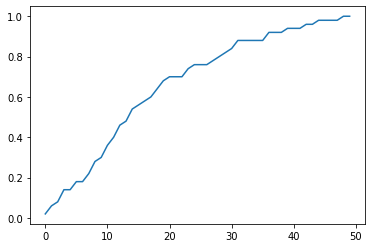

In [212]:
plt.plot(alarm)

# Classification

In [ ]:
vth_posterior = {}
vth_probs = np.linspace(0,1,15)
for key in excoefs.keys():
  V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
  V_windowed = max_filter1d_valid(V, W)
  V_windowed = V_windowed[np.isfinite(V_windowed)]
  if(len(V_windowed)>0):
    vth_indices = np.maximum(np.minimum(((1-vth_probs)*len(V_windowed)).astype('int'), len(V_windowed)-1), 0)
    vth_posterior[key] = V_windowed[vth_indices]
  else:
    vth_posterior[key] = np.ones(len(vth_probs))*np.nan

In [ ]:
threshold_dist = 5e-2
res = []
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
  alerts = np.zeros_like(vth_probs)
  matches = np.zeros_like(vth_probs)
  for cnt2, key in enumerate(excoefs.keys()):
     dist = distances[cnt,cnt2]
     if(dist <= threshold_dist):
       match = np.argwhere(stat_data[key].index==date).flatten()
       if(len(match)>0):
         match = match[0]
         matches += 1
         v_matched = np.sqrt(np.sum(excoefs[key][:,match-W:match][:2,:]**2,axis=0))
         v_matched = v_matched[np.isfinite(v_matched)]
         if(len(v_matched) > 0):
           v = np.max(v_matched)
           alerts += (v >= vth_posterior[key])
  res.append(alerts/matches)
res = np.array(res)
res = res[np.isfinite(res)].reshape(-1,res.shape[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


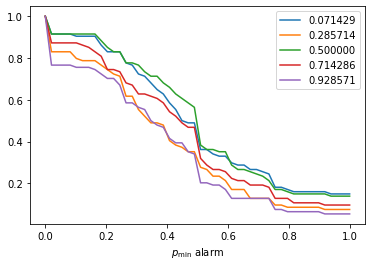

In [ ]:
for idx in range(1, len(vth_probs), 3):
  signaled = (res[:, idx].reshape(-1,1) >= np.linspace(0,1).reshape(1,-1)).mean(axis=0)
  plt.plot(np.linspace(0,1), signaled, label="%f" % vth_probs[idx])
plt.xlabel("$p_{\\rm min}$ alarm")
plt.legend()
plt.show()

In [ ]:
threshold_dist = 1e-2
probs = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res = []
for v_th_prob in probs:
  v_thresholds = {}
  for key in excoefs.keys():
    V = np.sqrt(np.sum(excoefs[key][:2,:]**2,axis=0))
    V = V[np.isfinite(V)]
    V = np.sort(V)
    v_th_idx = int(len(V)*(1-v_th_prob))
    if(len(V) == 0):
      v_thresholds[key] = np.infty
    else:
      v_thresholds[key] = V[v_th_idx]
    #plt.plot(V,np.linspace(0,1,len(V)))
    #plt.vlines(v_thresholds[key],0,1)
    #plt.xscale('log')
    #plt.show()
    #break
  signal_prob = []
  signal_magn = []
  for cnt, (date,row) in enumerate(earthquakes.iterrows()):
    match_cnt = 0
    alert_cnt = 0
    for cnt2, key in enumerate(excoefs.keys()):
       dist = distances[cnt,cnt2]
       if(dist <= threshold_dist):
         match = np.argwhere(stat_data[key].index==date).flatten()
         if(len(match)>0):
           match = match[0]
           v_matched = np.sqrt(np.sum(excoefs[key][:,match-W:match][:2,:]**2,axis=0))
           v_matched = v_matched[np.isfinite(v_matched)]
           if(len(v_matched) == W):
             match_cnt += 1
             if(np.max(v_matched) >= v_thresholds[key]):
               alert_cnt += 1
    if(match_cnt > 0):
      signal_prob.append(alert_cnt/match_cnt)
      signal_magn.append(row["m"])
  res.append( np.array(signal_prob) )
res = np.array(res)

In [ ]:
cuts = (res[:,np.newaxis,:]>np.linspace(0,1,20).reshape(1,-1,1)).astype('int')

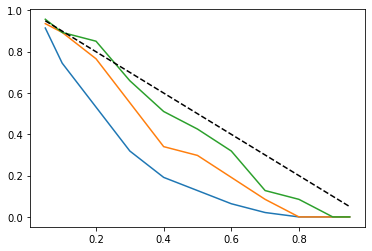

In [ ]:
plt.plot(probs, 1-cuts[:,5,:].mean(axis=-1))
plt.plot(probs, 1-cuts[:,10,:].mean(axis=-1))
plt.plot(probs, 1-cuts[:,15,:].mean(axis=-1))
plt.plot(probs,1-np.array(probs), ls='dashed', c='black')
plt.show()

In [ ]:
non_signaled = 1-cuts.sum(axis=2)/cuts.shape[2]

In [ ]:
non_signaled.shape

(11, 20)

# Discard

In [ ]:
m_day = catalog["m"].groupby("Date").apply(lambda x : (2/3)*np.log10(np.sum(10**(1.5*x))))
true_days = m_day.index
m_day = m_day.values
lat_day = catalog["lat"].groupby("Date").mean().values
long_day = catalog["long"].groupby("Date").mean().values
dep_day = catalog["dep"].groupby("Date").mean().values

In [ ]:
catalog_day = pd.DataFrame(columns = ["m", "lat", "long", "dep" ])

In [ ]:
catalog_day["m"] = m_day
catalog_day["lat"] = lat_day
catalog_day["long"] = long_day
catalog_day["dep"] = dep_day
catalog_day.index = true_days

In [ ]:
catalog_day.to_csv("catalog_day.csv", sep="\t")

# Pytorch

In [215]:
T_seq = 10
delta_days = np.timedelta64(T_seq, 'D')
max_distance = 5e-3
for cnt, (date,row) in enumerate(earthquakes.iterrows()):
  for key in stat_data.keys():
    pos = station_pos[key]
    dist = haversine(pos[0], row["lat"], pos[1]-row["long"])
    if(dist <= max_distance):
      match = stat_data[key][np.logical_and(stat_data[key].index < date,stat_data[key].index >= date - delta_days )]
      if((not match.empty) and (np.isfinite(match["N"]).all())):
        match = match[["N","E","U"]]

oaes
ldsw
crrs
monp
sio3
ldsw
corx
ldsw
ldes
opcl
sdhl
fvpk
sbcc
trak
whyt
coso
cuhs
coso
mvfd
oghs
p478
p482
p483
raap
cuhs
p066
p473
potr
sni1
p603
mvfd
p003
p478
p482
p484
p485
p486
pmob
mig1
nsss
coso
p473
potr
sni1
p473
potr
sni1
nsss
p473
potr
sni1
bomg
dhlg
p489
slms
bomg
dhlg
p489
p505
slms
bbdm
fgst
p010
bbdm
fgst
p010
p520
p548
501p
gmpk
monp
p472
p480
p481
p492
p493
p497
p498
p499
p502
p503
p509
p744
sio3
sio5
fgst
p010
fgst
p010
501p
crrs
fshb
gmpk
monp
p472
p480
p483
p492
p493
p495
p498
p499
p502
p503
p506
p509
raap
usgc
i40a
p603
p491
p504
fmtp
fmvt
mpwd
sfdm
p603
bbdm
copr
ucsb
p625
p006
